# Generate genre-based melodies using Magenta

## Download the Lakh MIDI Dataset (http://hog.ee.columbia.edu/craffel/lmd/) ##

In [2]:
import os
import shutil
import spotipy
import pickle
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter


if not os.path.exists('clean_midi'):
    # Download the 'Clean MIDI' dataset from http://colinraffel.com/projects/lmd/
    from six.moves import urllib
    import StringIO
    import gzip
    import tarfile
    FILE_URL = 'http://hog.ee.columbia.edu/craffel/lmd/clean_midi.tar.gz'
    response = urllib.request.urlopen(FILE_URL)
    print("INFO: Downloaded {}".format(FILE_URL))
    compressedFile = StringIO.StringIO()
    compressedFile.write(response.read())
    compressedFile.seek(0)
    decompressedFile = gzip.GzipFile(fileobj=compressedFile, mode='rb')
    OUTFILE_PATH = 'clean_midi.tar'
    with open(OUTFILE_PATH, 'wb') as outfile:
        outfile.write(decompressedFile.read())
    tar = tarfile.open(OUTFILE_PATH)
    tar.extractall()
    tar.close()
    print("INFO: Extracted data")
else:
    print("INFO: Found `clean_midi` directory")

## Preprocessing ##

Create author-genre dictionary for preprocessing and analysis

In [ ]:
if not os.path.exists("genres.p"):
    # Use Spotify's API to genre lookup. Login first and get your OAuth token: 
    # https://developer.spotify.com/web-api/search-item/
    # NOTE: Replace `AUTH` value with your token.
    AUTH = "ENTER-MY-AUTH-KEY"

    # Get artists from folder names
    artists = [item for item in os.listdir('clean_midi') if not item.startswith('.')]

    sp = spotipy.Spotify(auth=AUTH)
    genres = {}
    for i,artist in enumerate(artists):
        try:
            results = sp.search(q=artist, type='artist',limit=1)
            items = results['artists']['items']
            genre_list = items[0]['genres'] if len(items) else items['genres']
            genres[artist] = genre_list
            if i < 5:
                print("INFO: Preview {}/5".format(i + 1),
                      artist, genre_list[:5])
        except Exception as e:
            print("INFO: ", artist, "not included: ", e)

    # Save to pickle file
    pickle.dump(genres,open("genres.p","wb"))
else:
    # Load genres meta-data
    genres = pickle.load(open("genres.p","rb"))

### Examine distribution of genres in dataset

In [13]:
# Get the most common genres
flattened_list = [item for sublist in list(genres.values()) for item in sublist]
c = Counter(flattened_list)
c.most_common()[:20]

[('mellow gold', 385),
 ('soft rock', 373),
 ('rock', 355),
 ('classic rock', 289),
 ('album rock', 275),
 ('folk rock', 262),
 ('new wave pop', 247),
 ('adult standards', 235),
 ('brill building pop', 225),
 ('bubblegum pop', 208),
 ('christmas', 191),
 ('disco', 190),
 ('motown', 187),
 ('classic funk rock', 182),
 ('rock-and-roll', 175),
 ('singer-songwriter', 172),
 ('hard rock', 169),
 ('pop rock', 169),
 ('quiet storm', 169),
 ('soul', 167)]

### Load author-genre metadata into dataframe

In [337]:
# Convert labels to vectors
categories = set(sorted(list(flattened_list)))
df = pd.DataFrame(columns=categories)

for author,genre_list in genres.items():
    row = pd.Series(np.zeros(len(categories)),name=author)
    for ind,genre in enumerate(categories):
        if genre in genre_list:
            row[ind] = 1
    d = pd.DataFrame(row).T
    d.columns = categories
    df = pd.concat([df,d])
df = df.reindex_axis(sorted(df.columns), axis=1)

# Assign label for each author corresponding with meta-genre (eg, rock, classical)
def getStyle(genre_substring):
    """Get data where features contain `genre_substring`."""
    style_index = np.asarray([genre_substring in x for x in df.columns])
    style_array = df.iloc[:,style_index].any(axis=1)
    return style_array

# Create array of color/labels
color_array = np.zeros(df.shape[0])
genre_labels = ['other','rock','metal','pop','mellow','country', 'rap','classical']
for i,g in enumerate(genre_labels):
    if g == 'other':
        pass
    else:
        color_array[np.where(getStyle(g))] = i

### Visualize author classification by genre using TSNE and PCA ###

In [175]:
# 2-dimensions
model = TSNE(random_state=0)
np.set_printoptions(suppress=True)
X_tsne = model.fit_transform(df.values)
X_pca = PCA().fit_transform(df.values)

# 3-dimensions
model3d = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)
X_tsne3d = model3d.fit_transform(df.values)
X_pca3d = PCA(n_components=3).fit_transform(df.values)

Populating the interactive namespace from numpy and matplotlib


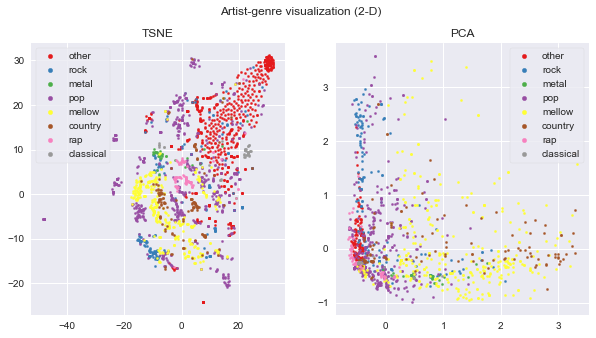

In [345]:
%pylab inline
CMAP_NAME = 'Set1'
cmap = matplotlib.cm.get_cmap(CMAP_NAME,lut=max(color_array)+1)
figure(figsize=(10, 5))
suptitle('Artist-genre visualization (2-D)')
axes_tsne = []
axes_pca = []

# TSNE
subplot(121)
title('TSNE')
for l in set(color_array):
    ax = plt.scatter(X_tsne[color_array==l][:, 0], X_tsne[color_array==l][:, 1],c=cmap(l/max(color_array)), s=5)
    axes_tsne.append(ax)
legend(handles=axes_tsne, labels=genre_labels,frameon=True,markerscale=2)

# PCA
subplot(122)
title('PCA')
for l in set(color_array):
    ax = plt.scatter(X_pca[color_array==l][:, 0], X_pca[color_array==l][:, 1],c=cmap(l/max(color_array)), s=5)
    axes_pca.append(ax)

legend(handles=axes_pca, labels=genre_labels,frameon=True,markerscale=2)
plt.show()

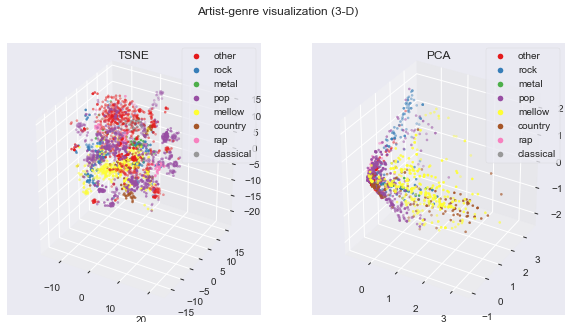

In [348]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 5))
suptitle('Artist-genre visualization (3-D)')
ax = fig.add_subplot(121, projection='3d')
title('TSNE')
axes_tsne = []
axes_pca = []
scatter_proxies = []
for l in set(color_array):
    ax.scatter(X_tsne3d[color_array==l][:, 0], X_tsne3d[color_array==l][:, 1],X_tsne3d[color_array==l][:, 2],c=cmap(l/max(color_array)), s=5,zdir='x')
    axes_tsne.append(fig.gca())
    proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=cmap(l/max(color_array)), marker = 'o')
    scatter_proxies.append(proxy)                                

legend(handles=scatter_proxies, labels=genre_labels,numpoints=1,frameon=True,markerscale=0.8)
ax2 = fig.add_subplot(122, projection='3d')
title('PCA')
for l in set(color_array):        
    ax2.scatter(X_pca3d[color_array==l][:, 0], X_pca3d[color_array==l][:, 1], X_pca3d[color_array==l][:, 2],c=cmap(l/max(color_array)),s=5)
    axes_pca.append(fig.gca())
    
legend(handles=scatter_proxies, labels=genre_labels,numpoints=1,frameon=True,markerscale=0.8)
plt.show()

#### Choose 2 genres with many artists and with unlikely overlap
Metal and classical are two candidates.

In [5]:
MIDI_DIR = os.path.join(os.getcwd(),'clean_midi')

def get_artists(genre):
    """Get artists with label `genre`."""
    artists = [artist for artist, gs in genres.items() if genre in gs]
    return artists

# Get artist with genres 'soft rock' and 'disco'
genre_data = {}
metal = get_artists('metal')
classical = get_artists('classical')

genre_data['metal'] = metal
genre_data['classical'] = classical

# Copy artists to a genre-specific folder
for genre, artists in genre_data.items():
    try:
        for artist in artists:
            _genre = genre.replace(' ','_').replace('&','n')
            shutil.copytree(os.path.join(MIDI_DIR,artist),os.path.join(os.getcwd(),'subsets',_genre,artist))
    except Exception as e:
        print(e)

## Deep learning genre melodies

### Convert MIDIs to NoteSequence using Magenta's script

Run `./train_model.sh` in project directory, or enter the following commands in the `subset` folder and create corresponding `.tfrecord` files:

```sh
for genre in */
  do
    if [[ $genre == *examples* ]]
    then continue
    fi
    convert_dir_to_note_sequences \
    --input_dir=$genre \
    --output_file=/tmp/${genre%/}_notesequences.tfrecord \
    --recursive && echo "INFO: ${genre%/} converted to NoteSequences"
  done
```

The `subsets` folder content should now contain `.tfrecord` files:

```bash
classical/                        metal/
classical_notesequences.tfrecord  metal_notesequences.tfrecord
```

Create the melody datasets for each genre:

```bash
for genre in */
  do
    if [[ $genre == *examples* ]]
    then continue
    fi
    melody_rnn_create_dataset \
    --config=attention_rnn \
    --input=/tmp/${genre%/}_notesequences.tfrecord \
    --output_dir=sequence_examples/${genre} \
    --eval_ratio=0.10 && echo "INFO: ${genre%/} database created."
  done
```

Now train the model:

```bash
  for genre in */
  do
    if [[ $genre == *examples* ]]
    then continue
    fi
    melody_rnn_train \
    --config=attention_rnn \
    --run_dir=/tmp/melody_rnn/logdir/run1/${genre} \
    --sequence_example_file=$(pwd)/sequence_examples/${genre%/}/training_melodies.tfrecord \
    --hparams="batch_size=64,rnn_layer_sizes=[64,64]" \
    --num_training_steps=2000 && echo "INFO: ${genre%/} model trained."
  done
```

Generate melodies:

```bash
for genre in */ ;
  do
    if [[ $genre == *examples* ]];
    then continue
    fi
    melody_rnn_generate \
    --config=attention_rnn \
    --run_dir=/tmp/melody_rnn/logdir/run1/${genre} \
    --output_dir=/tmp/melody_rnn/generated/${genre} \
    --num_outputs=10 \
    --num_steps=128 \
    --hparams="batch_size=64,rnn_layer_sizes=[64,64]" \
    --primer_melody="[60]" && echo "INFO: ${genre%/} melodies generated."
  done
```

Your melodies can be found in `/tmp/melody_rnn/generated/[genre]`. [Convert](https://github.com/JustinShenk/genre-melodies#postprocessing) to mp3's to play on modern browser or OS.